In [1]:
using Pkg
Pkg.add("TestImages")

   Updating registry at `C:\Users\i am\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\i am\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\i am\.julia\environments\v1.5\Manifest.toml`


In [2]:
using ArchGDAL, CSV, DataFrames
using ImageTransformations, CoordinateTransformations, Rotations, Plots

In [3]:
function closest_index(x::Array{T,1}, val::Q) where {T <: Number, Q <: Number}
    ibest = 1
    dxbest = abs(x[ibest]-val)
    for I in 1:length(x)
        dx = abs(x[I]-val)
        if dx < dxbest
            dxbest = dx
            ibest = I
        end
    end
    ibest
end
function closest_index(x::Array{T,1}, val::Array{Q,1}) where {T <: Number, Q <: Number}
    [closest_index(x,val[i]) for i in 1:length(val)]
end
function resize_cube(cube::Array{T,3},ratio) where T
	band1 = imresize(cube[:,:,1],ratio=ratio)
	cubeR = Array{typeof(band1[1]),3}(
		undef, 
		size(band1)[1],
		size(band1)[2],
		size(cube)[3]
	)
	cubeR[:,:,1]=band1
	for i in 2:size(cube)[3]
		cubeR[:,:,i] = imresize(cube[:,:,i],ratio=ratio)
	end
	cubeR
end
function resize_cube(cube::Array{T,2},ratio) where T
	imresize(cube,ratio=ratio)
end
function get_ranges(cube)
	minimums = Array{typeof(cube[1]),1}(undef,size(cube)[3])
	maximums = Array{typeof(cube[1]),1}(undef,size(cube)[3])
	for i in 1:size(cube)[3]
        try
            minimums[i] = minimum(filter(!iszero,cube[:,:,i]))
            #above errors if all elements are 0
        catch e
            println(e)
            minimums[i] = 0
        end            
		maximums[i] = maximum(cube[:,:,i])
	end
	[(minimums[i],maximums[i]) for i in 1:length(maximums)]
end

get_ranges (generic function with 1 method)

In [ ]:
function fix_points(first_e::Array{Array{Int,1},1})
    # find usable points
    usable = [true for _ in first_e]
    max_width = maximum([i[2] for i in first_e])
    max_height = maximum([i[1] for i in first_e])
    for i in 1:length(first_e)
        if first_e[i][1] == max_height || first_e[i][1] == 1
            if first_e[i][2] == max_width || first_e[i][2] == 1
                usable[i] = false
            end
        end 
    end
    
    fixed = true
    #fixing A
    if !usable[1]
        if !usable[4]
            fixed = false
        else
            first_e[1][2] = max_width - first_e[3][2]
        end
    end
    #fixing B
    if !usable[2]
        if !usable[3]
            fixed = false
        else
            first_e[2][1] = max_height - first_e[3][1]
        end
    end    
    #fixing C
    if !usable[3]
        if !usable[2]
            fixed = false
        else
            first_e[3][1] = max_height - first_e[2][1]
        end
    end
    #fixing D
    if !usable[4]
        if !usable[1]
            fixed = false
        else
            first_e[4][2] = max_width - first_e[1][2]
        end
    end
    first_e
end

In [ ]:
function find_points_of_square(band::Array{T,2}) where T
	#A B
	#C D
	width = size(band)[2]
	height = size(band)[1]
	##########################	A
	i = 1
	found = false
	while i<width && !found
		if !M_iszero(band[1,i])
			found = true
		else
			i = i+1
		end
	end
	A = [1,i]
	##########################	B
	i = 1
	found = false
	while i<height && !found
		if !M_iszero(band[i,width])
			found = true
		else
			i = i+1
		end
	end
	B = [i, width]
	##########################	C
	i = 1
	found = false
	while i>height && !found
		if !M_iszero(band[i,1])
			found = true
		else
			i = i+1
		end
	end
	C = [height,i]
	##########################	D
	i = 1
	found = false
	while i<width && !found
		if !M_iszero(band[height,i])
			found = true
		else
			i = i+1
		end
	end
	D = [height,i]
	[A, B, C, D]
end
function find_points_of_square(cube::Array{T,3}) where T
	[find_points_of_square(cube[:,:,i]) for i in 1:size(cube)[3]]
end

In [162]:
function calc_angle(points::Array{Array{Int,1},1})
    opposite = points[1][2]
    adjacent = points[3][1]
    cot(opposite/adjacent)
end
function tilt_band(first_e, img)
    opposite = first_e[1][2] - max_width
    adjacent = first_e[2][1]
    angle = cot(opposite/adjacent)
    # define transformation
    trfm = recenter(RotMatrix(angle/π), ImageTransformations.center(img))
    collect(warp(img, trfm))
end

tilt_band (generic function with 2 methods)

In [ ]:
function M_iszero(x)
    iszero(x) || isnan(x)
end
function crop_out_zeros(band::Array{T,2}) where T
    width = size(band)[2]
    height = size(band)[1]
    #1 find how many rows we snip from 0
    UProws = 0
    i=1
    found= false
    while !found
        if count(!M_iszero,band[i,:])>0
            found = true
            UProws = i
        else
            i = i+1
        end
    end
    #2 find rows to snip from the bottom
    DOrows=0
    i=0
    found= false
    while !found
        if count(!M_iszero,band[height-i,:])>0
            found = true
            DOrows = i
        else
            i = i + 1
        end
    end
    #3 find cols to snip from the left
    Lcols=0
    i=1
    found= false
    while !found
        if count(!M_iszero,band[:,i])>0
            found = true
            Lcols = i
        else
            i = i+1
        end
    end
    #4 find cols to snip from the right
    Rcols=0
    i=0
    found= false
    while !found
        if count(!M_iszero,band[:,width-i])>0
            found = true
            Rcols = i
        else
            i = i+1
        end
    end
    #4 get cropped band
    band[UProws:(height-DOrows),Lcols:(width-Rcols)]
end

In [ ]:
function find_first(arr::Array{T,1}, f; reverse=false) where T
    len = length(arr)
    if reverse
        i = len
        while f(arr[i]) && i > 0
            i = i - 1
        end
    else
        i = 1
        while f(arr[i]) && i <= len
            i = i + 1
        end       
    end
    i
end
function find_lengths(band::Array{T,2}, f ; rows = true) where T
    if rows
        lengths = Array{Int,1}(undef, size(band)[1])
        for i in length(lengths)
            lengths[i] = find_first(band[i,:], f; reverse=true)-find_first(band[i,:], M_iszero) +  1
        end
    else
        lengths = Array{Int,1}(undef, size(band)[2])
        for i in length(lengths)
            lengths[i] = find_first(band[:,i], f; reverse=true)-find_first(band[:,i], M_iszero) +  1
        end
    end
    lengths
end
function NaN_zeros!(band)
    for i in 1:length(band)
        if band[i] == 0
            band[i] = NaN
        end
    end
    band
end
function zero_NaNs(band)
    for i in 1:length(band)
        if isnan(band[i])
            band[i] = 0
        end
    end
    band
end

In [194]:
function plot_cols(band)
    p = plot(legend=false)
    for i in 1:size(band)[2]
        plot!(filter(!iszero, band[:,i]))
    end
    p
end 

plot_cols (generic function with 1 method)

In [198]:
function plot_rows(band)    
    p = plot(legend=false)
    for i in 1:size(band)[1]        
        plot!(filter((x)->(x[2]!=0), [(band[i,j], j) for j in 1:length(band[i,:])]))
    end
    p
end

plot_rows (generic function with 1 method)

In [199]:
function plot_band(band)
    # 1 crop
    band = crop_out_zeros(band)
    # 2 find points
    points = fix_points(find_points_of_square(band))
    # 3 tilt
    band = zero_NaNs(crop_out_zeros(tilt_band(points, band)))
    # 4 resize
    band = imresize(band, ratio = 1/20)
    # 5 define plots
    hm = heatmap(band)
    
    rowp = plot_rows(band)
    
    colp = plot_cols(band)
    
    pad = plot()
    
    plot(colp, pad, hm, rowp)
end

plot_band (generic function with 1 method)

In [175]:
wvls = CSV.read("out/profiler_test_VNIR.wvl", DataFrame)
# parameters
tiff = "out/profiler_test_VNIR.tif"
bands = [4,5,6,7,8,9,10,55,21]
#####
dataset = ArchGDAL.read(tiff)
cube = Array{typeof(ArchGDAL.getband(dataset, 1)[1,1]),3}(
	undef,
	ArchGDAL.width(dataset),
	ArchGDAL.height(dataset), 
	length(bands)
)
for i in 1:length(bands)
	global cube[:,:,i] = ArchGDAL.getband(dataset, bands[i])
end

In [ ]:
plot_band(cube[:,:,3])

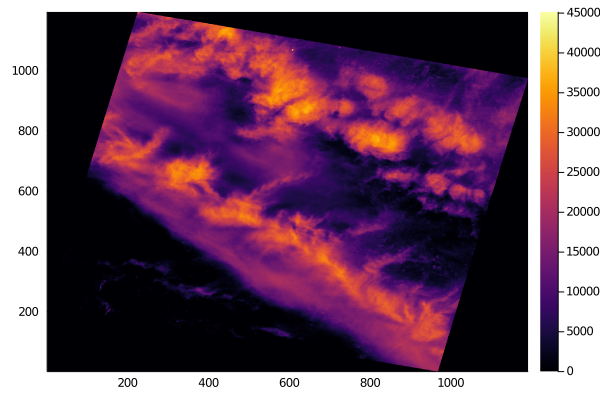

In [11]:
cropped_band = crop_out_zeros(cube[:,:,2])
heatmap(cropped_band)

In [45]:
points =  [find_points_of_square(cropped_band)]
first_e = points[1]

4-element Array{Array{Int64,1},1}:
 [1, 965]
 [973, 1190]
 [1194, 1]
 [1194, 224]

In [46]:
fix_points(find_points_of_square(cropped_band))

4-element Array{Array{Int64,1},1}:
 [1, 965]
 [973, 1190]
 [221, 1]
 [1194, 224]

In [47]:
# check1, all points are same?
found_different = false
for i in points
    if i != first_e
        global found_different = true
    end
end
found_different

false

In [48]:
#check 2,  impossible points?
usable = [true for _ in points[1]]
max_width = size(cropped_cube)[2]
max_height = size(cropped_cube)[1]
for i in 1:length(points[1])
    if points[1][i][1] == max_height || points[1][i][1] == 1
        if points[1][i][2] == max_width || points[1][i][2] == 1
            usable[i] = false
        end
    end   
        
end
usable

4-element Array{Bool,1}:
 1
 1
 1
 1

In [49]:
#calculate bad points using good points
fixed = true
max_width = size(cropped_cube)[2]
max_height = size(cropped_cube)[1]
max_height, max_width

(1194, 1190)

In [50]:
#fixing A
if !usable[1]
    if !usable[4]
        fixed = false
    else
        first_e[1][2] = max_width - first_e[3][2]
    end
end
#fixing B
if !usable[2]
    if !usable[3]
        fixed = false
    else
        first_e[2][1] = max_height - first_e[3][1]
    end
end    
#fixing C
if !usable[3]
    if !usable[2]
        fixed = false
    else
        first_e[3][1] = max_height - first_e[2][1]
    end
end
#fixing D
if !usable[4]
    if !usable[1]
        fixed = false
    else
        first_e[4][2] = max_width - first_e[1][2]
    end
end
first_e

4-element Array{Array{Int64,1},1}:
 [1, 965]
 [973, 1190]
 [221, 1]
 [1194, 224]

In [51]:
?RotM

true

In [52]:
resized_cube = cropped_cube
first_e

4-element Array{Array{Int64,1},1}:
 [1, 965]
 [973, 1190]
 [221, 1]
 [1194, 224]

In [53]:
opposite = first_e[1][2] - max_width
adjacent = first_e[2][1]
angle = cot(opposite/adjacent)
# define transformation
img = resized_cube[:,:]
trfm = recenter(RotMatrix(angle/π), ImageTransformations.center(img))
imgw = warp(img, trfm)

1422×1424 OffsetArray(::Array{Float64,2}, -113:1308, -116:1307) with eltype Float64 with indices -113:1308×-116:1307:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN

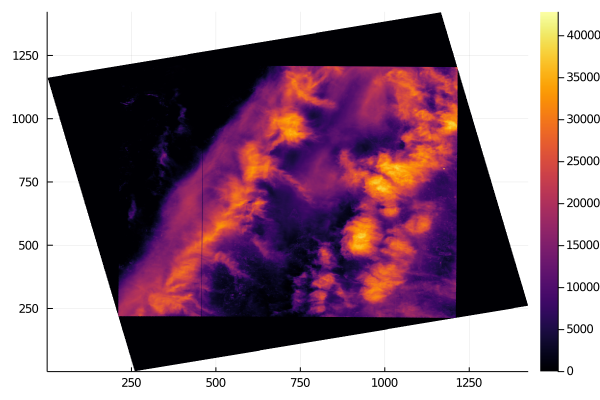

In [54]:
tilted_band = collect(imgw)
heatmap(tilted_band)

In [55]:
curated_band = crop_out_zeros(collect(imgw))

1000×1007 Array{Float64,2}:
  NaN      NaN      NaN        0.0   …    NaN      NaN    NaN    NaN
  NaN      NaN      NaN        0.0        NaN      NaN    NaN    NaN
  NaN      NaN      NaN        0.0          0.0    NaN    NaN    NaN
  NaN      NaN        0.0      0.0          0.0      0.0    0.0    0.0
  NaN      NaN        0.0      0.0          0.0      0.0    0.0    0.0
  NaN      NaN        0.0      0.0   …      0.0      0.0    0.0    0.0
  NaN      NaN        0.0      0.0          0.0      0.0    0.0    0.0
  NaN        0.0      0.0   4264.74         0.0      0.0    0.0    0.0
  NaN    12384.5  10537.3  19507.3          0.0      0.0    0.0    0.0
  NaN    19424.4  19419.6  19506.9          0.0      0.0    0.0    0.0
  NaN    15524.4  19278.2  19439.6   …      0.0      0.0    0.0    0.0
  NaN    17041.0  19302.3  19425.9          0.0      0.0    0.0    0.0
 2397.5  19176.0  19207.3  19381.8          0.0      0.0    0.0    0.0
    ⋮                                ⋱                 

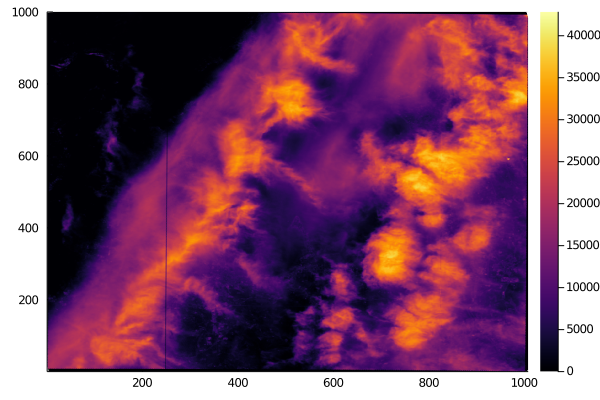

In [56]:
heatmap(curated_band)

In [114]:
zero_NaNs(resized_curated)

50×51 Array{Float64,2}:
 19901.8     17625.8   20789.9     24333.4    …  12060.9    6792.46   6815.25
 19611.3     18500.0   18007.7     24583.2        6875.37   6654.65   4243.76
 19466.2     20264.3   18812.1     19982.7        7030.59   7890.91   6149.22
 16158.3     19878.9   21974.0     20607.6        8769.31   8283.22   8900.24
 14345.7     18482.6   19946.1     21366.3       11519.5   13172.2   13055.1
 13156.0     16593.6   19644.2     20966.8    …  12411.0   12370.9   14453.6
  9860.11    13944.1   17483.8     19760.9       10008.7   10798.6   14764.3
  6726.94    11990.5   15177.7     18096.3        8141.72  13183.8   13305.9
  4195.75     8233.77  12717.1     15857.2        5824.45   5344.7    9863.83
  1732.21     6720.11   8800.55    14210.5        5830.16   5846.71  10350.9
   549.625    2858.8    7965.33    11272.2    …   6119.42   4436.71   9028.44
     0.0      1278.99   2611.47     8065.45       5480.62   4680.09   6963.2
     0.0         0.0    1432.58     3536.83   

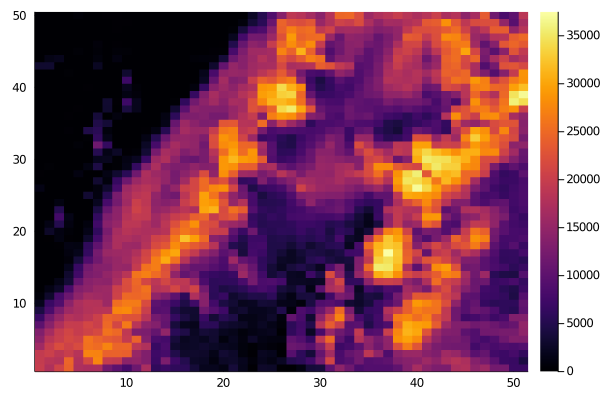

In [115]:
heatmap(resized_curated)

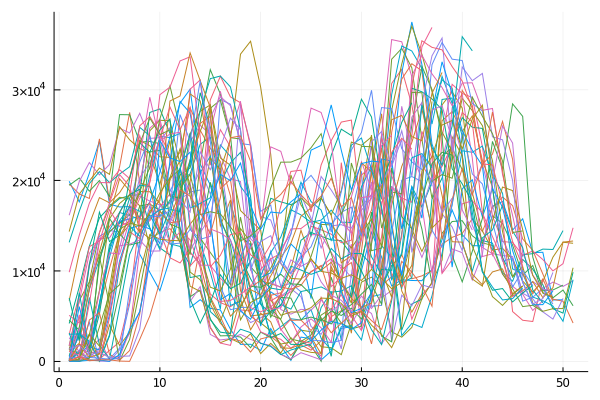

In [159]:
plot_rows(resized_curated)

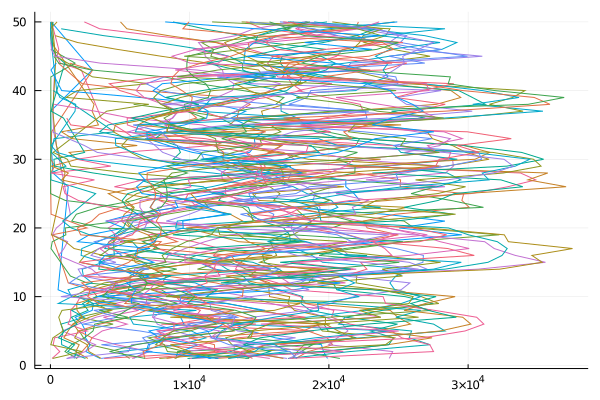

In [160]:
plot_cols(resized_curated)

In [63]:
points3 = fix_points(points2)

4-element Array{Array{Int64,1},1}:
 [1, 977]
 [850, 1007]
 [150, 1]
 [1000, 35]

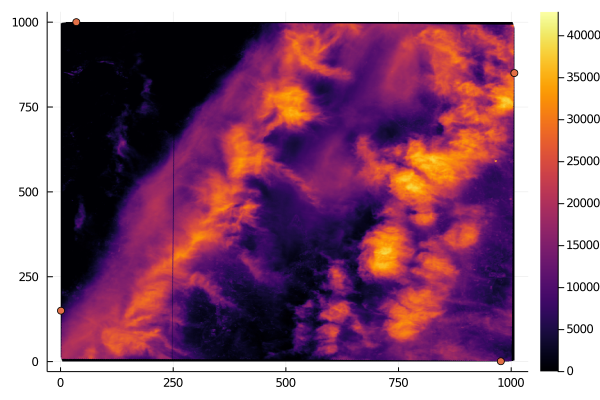

In [74]:
heatmap(curated_band)
scatter!([i[2] for i in points2],[i[1] for i in points2],legend=false)